In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import linear_model
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import ctar

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [96]:
### simulate data ###

# Simulation parameters
n_rep = 1
n_cell = 100000 # cells total
n = 1 # peak-gene pairs

alpha = 0.2
beta = 0.7
mu = 0
sigma = 1
b_true = 0.5

# Simulation
data_simu = {}
for i_rep in range(n_rep):
    
    np.random.seed(99 + i_rep)
    print(f'rep {i_rep}')
    data_simu[i_rep] = {}
    
    # simulate the parameters
    lam_simulated = np.random.gamma(alpha, beta, size=n_cell)  # lam ~ Gamma(alpha, beta)
    print("Min lam:", lam_simulated.min(), "Max lam:", lam_simulated.max())
    
    # simulate the Poisson data
    rate_y = np.exp(lam_simulated * b_true) # rate
    print("Min rate:", rate_y.min(), "Max rate:", rate_y.max())    
    data_simu[i_rep]['x'] = np.random.poisson(lam_simulated)  # X ~ Poisson(lam)
    data_simu[i_rep]['y'] = np.random.poisson(rate_y)  # Y ~ Poisson(exp(lam * b))
    print('y_lam_b',ctar.method.fit_poisson(lam_simulated,data_simu[i_rep]['y']))
    print('y_x_b',ctar.method.fit_poisson(data_simu[i_rep]['x'],data_simu[i_rep]['y']))
    print('')


rep 0
Min lam: 5.126229063698346e-31 Max lam: 6.0459644389964
Min rate: 1.0 Max rate: 20.552492425460727
y_lam_b 0.4944642403683197
y_x_b 0.223933263758291



PoiReg y against lambda_c should recover b.

In [93]:
# map estimate

b_est_bayes = np.zeros(n_rep)
b_est_poireg = np.zeros(n_rep)

# for i_rep in range(n_rep):

x_simulated,y_simulated = data_simu[i_rep]['x'],data_simu[i_rep]['y']

# sample moments
mean_X_c = np.mean(x_simulated)  # Sample mean of X_c
mean_X_c2 = np.mean(x_simulated**2)  # Sample second moment (E[X_c^2])
# alpha and beta using the formulas
beta_est = ((mean_X_c2 - mean_X_c**2 - mean_X_c) / mean_X_c)
alpha_est = ((mean_X_c**2) / (mean_X_c2 - mean_X_c**2 - mean_X_c))
print('alpha_est', alpha_est)
print('beta_est', beta_est)

with pm.Model() as model:

    b = pm.Normal("b", mu=mu, sigma=100) # prior for b
    # b = pm.Uniform("b", lower=-1, upper=1) # prior for b
    # b = pm.Normal("b", mu=mu, sigma=100) # prior for b
    # lam = pm.Gamma("lam", alpha=alpha_est, beta=beta_est, shape=n_cell) # prior for lam
    lam = pm.Gamma("lam", alpha=alpha, beta=beta, shape=n_cell) # prior for lam
    rate_y = pm.math.clip(np.exp(lam * b), 1e-5,1e5)
    # rate_y = np.exp(lam * b)
    
    # likelihoods on observed data
    x_obs = pm.Poisson("x", mu=lam, observed=x_simulated)  # observed x
    y_obs = pm.Poisson("y", mu=rate_y, observed=y_simulated)  # observed y
    
    # find map
    # map_estimate = pm.find_MAP(
    #     start={"lam": x_simulated.clip(min=0.01), "b":0.5,}
    # ) 
    map_estimate = pm.sample()
print("map_estimate['b']", map_estimate['b'])
b_est_bayes[i_rep] = map_estimate['b']

# 
b_poiregr = ctar.method.fit_poisson(x_simulated,y_simulated)
print('PoiReg', b_poiregr) # point estimate
b_est_poireg[i_rep] = b_poiregr
print('')

print('b_est_bayes', np.mean(b_est_bayes), np.std(b_est_bayes))
print('b_est_poireg', np.mean(b_est_poireg), np.std(b_est_poireg))

        
# plt.scatter(beta,beta_est)
# plt.xlabel('beta')
# plt.ylabel('beta_est')
# plt.plot([0,1],[0,1],c='r')
# plt.show()

# plt.scatter(alpha,alpha_est)
# plt.xlabel('alpha')
# plt.ylabel('alpha_est')
# plt.plot([0,1],[0,1],c='r')
# plt.show()

alpha_est 0.2010054277008771
beta_est 0.6966478547454117


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, lam]


Output()

ValueError: Not enough samples to build a trace.

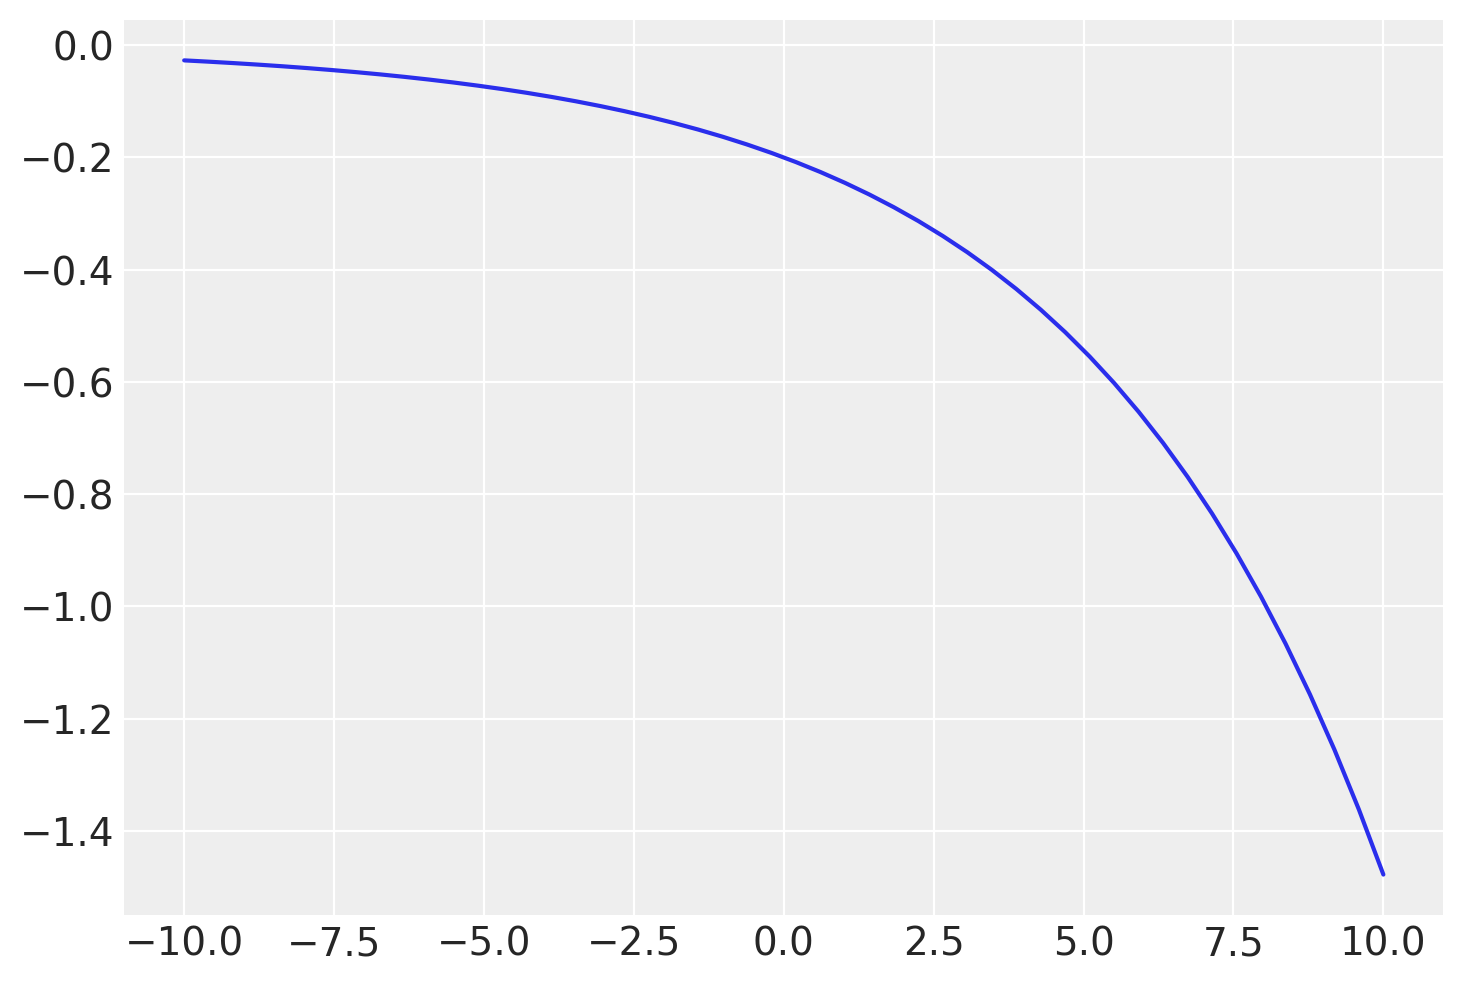

In [6]:
x = np.linspace(-10,10)
x_i = 0
y_i = 5
b = 0.2
plt.plot(x,(x_i / x) + y_i * b - 1 - b * np.exp(x * b))
plt.show()

In [7]:
def binary_search(x_i,y_i,b,tol=1e-6):

    if x_i == 0:
        x_i = np.clip(x_i,1e-6,1e6)
    
    def derivative(lam_):
        # derivative of log likelihood func
        return (x_i / lam_) + y_i * b - 1 - b * np.exp(lam_ * b) ## !!

    # random initializations
    lam_min = min(x_i,(1/b)*np.log(y_i).clip(0)) # should be nonzero
    lam_max = max(x_i,(1/b)*np.log(y_i))
    lam_mid_grad = 10

    # print('init_lam_max',lam_max)
    # print('init_lam_min',lam_min)
        
    while abs(lam_max - lam_min) > tol :

        lam_mid = (lam_min + lam_max) / 2 # midpoint
        lam_mid_grad = derivative(lam_mid) # evaluate at midpoint
        
        if lam_mid_grad == 0: # midpoint evals to 0
            return lam_mid
        elif lam_mid_grad < 0: # midpoint evals to negative
            lam_max = lam_mid
        else: # midpoint evals to positive
            lam_min = lam_mid

        # print('lam_min',lam_min)
        # print('lam_max',lam_max)
        # print('lam_mid',lam_mid)
        # print('grad',lam_mid_grad)
        # print('diff',lam_max - lam_min)
        # print('')
    
    return (lam_min + lam_max) / 2 # if derivative = 0 not reached

/tmp/ipykernel_64632/4101279388.py:5: RuntimeWarning: invalid value encountered in log
  plt.plot(lam_,x_i * np.log(lam_) - lam_ + y_i * lam_ * b \


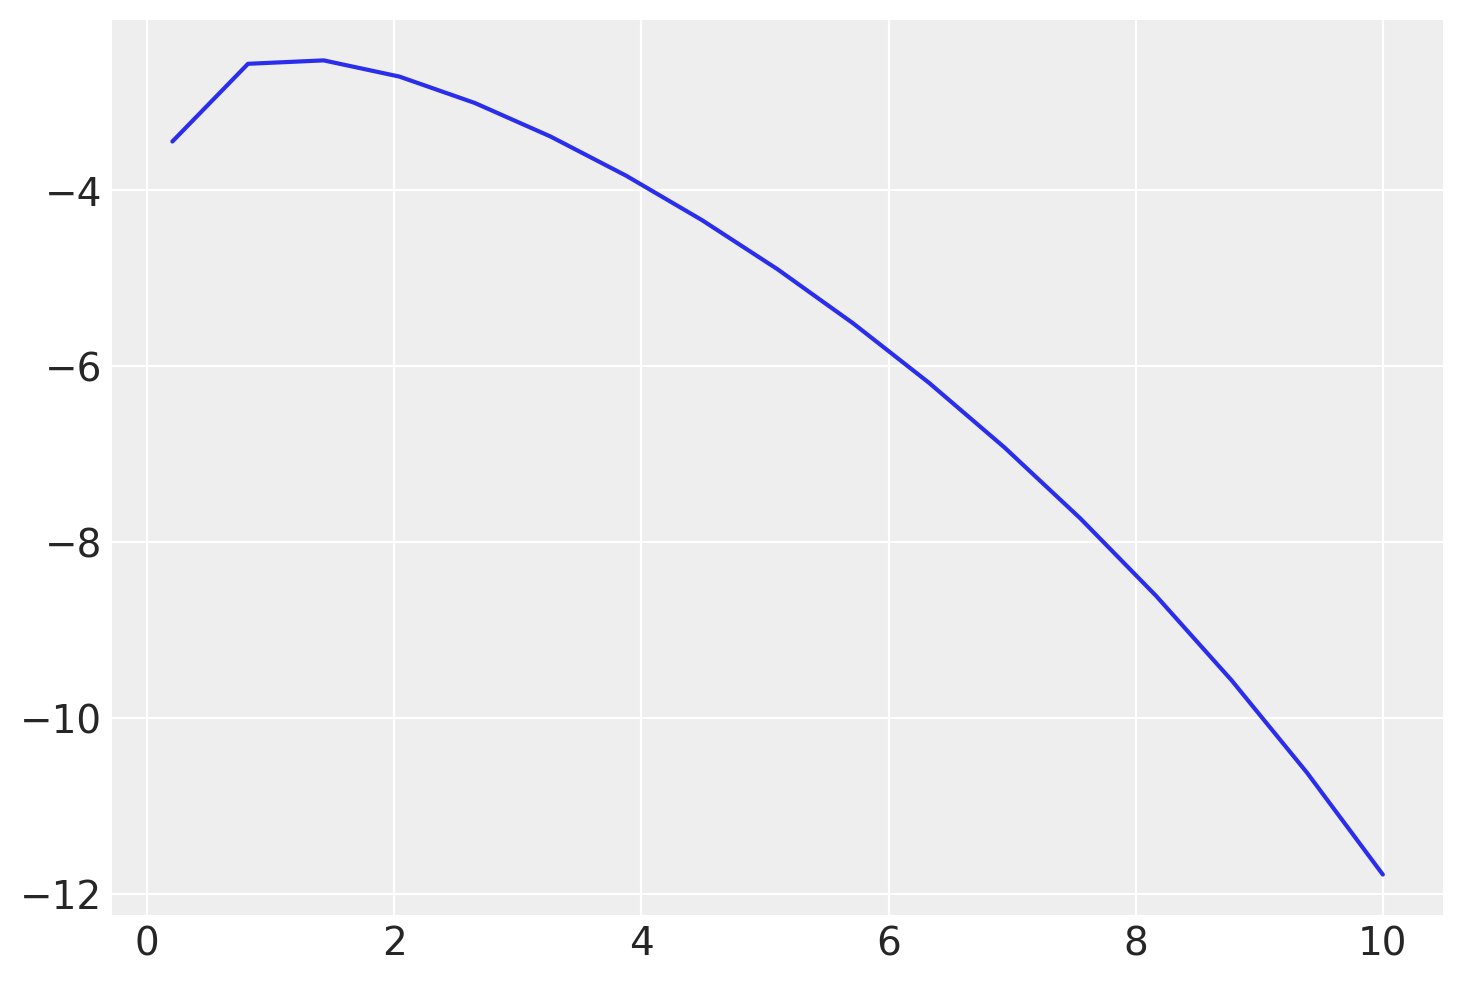

In [9]:
lam_ = np.linspace(-20,10)
x_i = 1
y_i = 2
b = 0.2
plt.plot(lam_,x_i * np.log(lam_) - lam_ + y_i * lam_ * b \
                - np.exp(lam_ * b) - np.log(math.factorial(x_i)) - np.log(math.factorial(y_i)))
plt.show()

In [8]:
def grad_descent(x_i,y_i,b,rate=0.02,max_iter=1000):

    def loglikelihood(lam_):
        return x_i * np.log(lam_) - lam_ + y_i * lam_ * b \
                - np.exp(lam_ * b) - np.log(math.factorial(x_i)) - np.log(math.factorial(y_i))

    def gradient(lam_):
        # derivative of log likelihood func
        return (x_i / lam_) + y_i * b - 1 - b * np.exp(lam_ * b)

    # random initializations
    lam = x_i
    lam_hist = [x_i]

    for x in range(max_iter):
        
        lam = (lam + rate * gradient(lam)).clip(0)
        lam_hist.append(lam)
    
    return lam

In [5]:
index_list = [0,6,10,21]
print(data_simu[0]['x'][index_list])
print(data_simu[0]['y'][index_list])

[0 0 1 0]
[1 0 0 1]


In [97]:
ctar.method.fit_poisson(lam_simulated,data_simu[0]['y'])

0.4944642403683197

In [98]:
# EM estimate
max_iter = 100

x_simulated,y_simulated = data_simu[0]['x'],data_simu[0]['y']
print(data_simu[0]['x'][index_list])
print(data_simu[0]['y'][index_list])
print('regr_b',ctar.method.fit_poisson(x_simulated,y_simulated))
print('y_lam_b',ctar.method.fit_poisson(lam_simulated,y_simulated))
print('')

# latent variables
for iter_i in range(max_iter):

    # initialization
    print('iter_i: ',iter_i)
    if iter_i == 0:
        lam_arr = x_simulated.astype(np.float64) # x is noisy lam
        b = ctar.method.fit_poisson(lam_arr,y_simulated) # poisson regr coeff estimate
        print('initializing...')
        print('b',b)
        print('')
        continue

    ratio = np.sum(x_simulated) / np.sum(lam_arr)
    lam_arr = lam_arr * ratio
    print('ratio',ratio)
    print('lam_arr',lam_arr[index_list])
    
    # given b, update lam
    for cell_i in range(n_cell):
        # binary search
        lam_arr[cell_i] = binary_search(x_simulated[cell_i],y_simulated[cell_i],b)
        # print(x_simulated[cell_i],y_simulated[cell_i], lam_arr[cell_i])
    print('x',data_simu[0]['x'][index_list])
    print('y',data_simu[0]['y'][index_list])
    print((data_simu[0]['y'][index_list]).clip(1e-6,1e6))
    print(np.log(data_simu[0]['y'][index_list].clip(1e-6,1e6)))
    print('lam_bound',(1/b) * np.log(data_simu[0]['y'][index_list].clip(1e-6,1e6)))
    print('lam_simulated',lam_simulated[index_list])
    print('lam',lam_arr[index_list])
    # print('lam nonzero',np.sum(lam > 1e-3))
    # print('lam std',np.std(lam))

    # given lam, update b
    b = ctar.method.fit_poisson(lam_arr,y_simulated) #.clip(-1e3,1e3)
    print('b_true',b_true)
    print('b',b)
    print('')
            

[1 1 0 0]
[1 3 2 2]
regr_b 0.223933263758291
y_lam_b 0.4944642403683197

iter_i:  0
initializing...
b 0.223933263758291

iter_i:  1
ratio 1.0
lam_arr [1. 1. 0. 0.]


/tmp/ipykernel_1115/1571085771.py:11: RuntimeWarning: divide by zero encountered in log
  lam_min = min(x_i,(1/b)*np.log(y_i).clip(0)) # should be nonzero
/tmp/ipykernel_1115/1571085771.py:12: RuntimeWarning: divide by zero encountered in log
  lam_max = max(x_i,(1/b)*np.log(y_i))


x [1 1 0 0]
y [1 3 2 2]
[1. 3. 2. 2.]
[0.         1.09861229 0.69314718 0.69314718]
lam_bound [0.         4.90598078 3.09532925 3.09532925]
lam_simulated [0.09612677 1.79849088 0.27608862 0.03503128]
lam [9.49612141e-01 1.55021772e+00 1.36899188e-06 1.36899188e-06]
b_true 0.5
b 0.2766123916418471

iter_i:  2
ratio 0.9053027904294656
lam_arr [8.59686521e-01 1.40341643e+00 1.23935217e-06 1.23935217e-06]
x [1 1 0 0]
y [1 3 2 2]
[1. 3. 2. 2.]
[0.         1.09861229 0.69314718 0.69314718]
lam_bound [0.         3.97166693 2.50584284 2.50584284]
lam_simulated [0.09612677 1.79849088 0.27608862 0.03503128]
lam [9.25336361e-01 1.64855331e+00 1.29871963e-06 1.29871963e-06]
b_true 0.5
b 0.3287163305126537

iter_i:  3
ratio 0.8980324883596799
lam_arr [8.30982115e-01 1.48045443e+00 1.16629242e-06 1.16629242e-06]
x [1 1 0 0]
y [1 3 2 2]
[1. 3. 2. 2.]
[0.         1.09861229 0.69314718 0.69314718]
lam_bound [0.         3.34212872 2.10864845 2.10864845]
lam_simulated [0.09612677 1.79849088 0.27608862 0.

KeyboardInterrupt: 